# Main core through time

Explore the main core of the citation network at different time windows.

In [1]:
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
cite = pd.read_csv("../data/processed/cites.csv")

cite = cite[(cite.t_year >= 1990) & (cite.t_year < 2020)]
cite = cite[(cite.s_year >= 1990) & (cite.s_year < 2020)]

cite = cite[cite.target != cite.source]

In [4]:
people = pd.read_csv("../data/processed/network_people.csv")
all_people = pd.read_csv("../data/processed/people.csv")

In [5]:
genders = dict(zip(all_people['Short-Id'], all_people['gender']))

places = pd.read_csv("../data/processed/institution.csv")

places = places[['Handle', 'Primary-Name', 'alpha-3', 'region', 'sub-region']].set_index("Handle")

all_people = pd.merge(all_people,
                  places,
                  left_on="Workplace-Institution",
                  right_index=True,
                  how="left")

all_people = all_people[all_people.region.notna()]

## Yearly time windows

In [9]:
graphs = []
years = []
for year in [2000, 2003] + list(range(2005, 2020)):
    years.append(year)
    if year == 2000:
        chunk = cite[cite.s_year <= year]
    elif year == 2003:
        chunk = cite[(cite.s_year > 2000) & (cite.s_year <= 2003)]
    elif year == 2005:
        chunk = cite[(cite.s_year > 2003) & (cite.s_year <= 2005)]
    else:
        chunk = cite[cite.s_year == year]
    G = nx.from_pandas_edgelist(chunk,
                                source="source",
                                target="target",
                                create_using=nx.DiGraph)
    G.remove_edges_from(nx.selfloop_edges(G))
    graphs.append(G)

In [10]:
core_nodes = []
ks = []
core_sizes = []
sizes = []
core_edges = []
edges = []
for g in graphs:
    sizes.append(len(g))
    edges.append(len(g.edges))
    core = nx.k_core(g)
    k = min(core.degree, key=lambda x: x[1])[1]
    core_nodes.append(list(core))
    core_sizes.append(len(core))
    ks.append(k)
    core_edges.append(len(core.edges))

In [11]:
females = []
for i, cn in enumerate(core_nodes):
    if i == 0:
        year = 2000
    elif i == 1:
        year = 2003
    else:
        year = 2005 + (i - 2)
        
    females.append(all_people[all_people["Short-Id"].isin(cn)].gender.value_counts(normalize=True).iloc[1])

In [12]:
df_core = pd.DataFrame({"Year": years, "Core nodes": core_sizes, "K": ks, "Core edges": core_edges,
                       "Women": females})

In [13]:
df_core["Year"] = df_core["Year"].astype(str)

In [14]:
df_core.corr(method="spearman")

,Core nodes,K,Core edges,Women
Core nodes,1.000000,-0.010475,0.989577,0.766401
K,-0.010475,1.000000,0.049262,0.142859
Core edges,0.989577,0.049262,1.000000,0.750000
Women,0.766401,0.142859,0.750000,1.000000


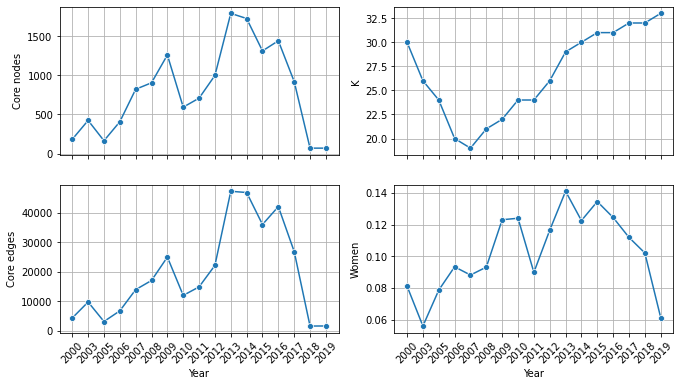

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(11, 6), sharex=True)

sns.lineplot(x="Year", y="Core nodes", marker="o", data=df_core, ax=axs[0][0])
sns.lineplot(x="Year", y="K", marker="o", data=df_core, ax=axs[0][1])
sns.lineplot(x="Year", y="Core edges", marker="o", data=df_core, ax=axs[1][0])
sns.lineplot(x="Year", y="Women", marker="o", data=df_core, ax=axs[1][1])
plt.setp(axs[1][0].get_xticklabels(), rotation=45)
plt.setp(axs[1][1].get_xticklabels(), rotation=45);
axs[0][0].grid(True)
axs[0][1].grid(True)
axs[1][0].grid(True)
axs[1][1].grid(True)
plt.savefig("../figures/k_core_evolution.png", dpi=300)

Let's now observe the outliers 

In [16]:
outliers = []
edges = []
edges_out = []
nodes = []
for g in graphs:
    degree = pd.DataFrame(g.in_degree,
                         columns=['a', 'd'])
    mu = degree['d'].mean()
    iqr = (degree['d'].quantile(.75) - degree['d'].quantile(.25))
    outs = list(degree[degree.d >= mu + 1.5 * iqr].a)
    outliers.append(outs)
    edges.append(degree.d.sum())
    edges_out.append(degree[degree.a.isin(outs)].d.sum())
    nodes.append(len(g))

In [17]:
years = []
females = []
for i, out in enumerate(outliers):
    if i == 0:
        year = 2000
    elif i == 1:
        year = 2003
    else:
        year = 2005 + (i - 2)
    print(year)
    print("Proportion of nodes", len(out) / nodes[i])
    print(f"Edges in {year}:", f"{edges[i]:,}")
    print("Proportion of edges", edges_out[i] / edges[i])
    print("number of people", all_people[all_people["Short-Id"].isin(out)].shape[0])
    print(all_people[all_people["Short-Id"].isin(out)].gender.value_counts(normalize=True))
    print("-" * 20)
    years.append(year)
    females.append(all_people[all_people["Short-Id"].isin(out)].gender.value_counts(normalize=True).iloc[1])

2000
Proportion of nodes 0.10451772976325856
Edges in 2000: 100,910
Proportion of edges 0.6160142701417104
number of people 811
male      0.938348
female    0.061652
Name: gender, dtype: float64
--------------------
2003
Proportion of nodes 0.11281462654751169
Edges in 2003: 125,754
Proportion of edges 0.6253160933250632
number of people 1117
male      0.917637
female    0.082363
Name: gender, dtype: float64
--------------------
2005
Proportion of nodes 0.1079043721731639
Edges in 2005: 131,197
Proportion of edges 0.6045031517488967
number of people 1224
male      0.916667
female    0.083333
Name: gender, dtype: float64
--------------------
2006
Proportion of nodes 0.10730455780259583
Edges in 2006: 95,316
Proportion of edges 0.5629799823744177
number of people 1180
male      0.913559
female    0.086441
Name: gender, dtype: float64
--------------------
2007
Proportion of nodes 0.10032519200166055
Edges in 2007: 110,571
Proportion of edges 0.5618290510169937
number of people 1198
male  

In [18]:
prop = pd.DataFrame({"Women": females, "Year": years})

In [19]:
prop['Year'] = prop.Year.astype(str)

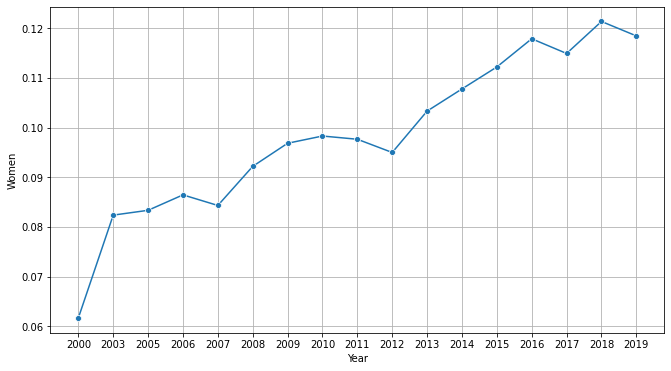

In [20]:
fig, ax = plt.subplots(figsize=(11, 6))
sns.lineplot(x="Year", y="Women", marker="o", data=prop, ax=ax)
plt.grid(True)
plt.savefig("../figures/outliers_evolution.png", dpi=300)

## Femec development by region

In [21]:
all_people.region.value_counts()

Europe      26066
Americas    13746
Asia         5810
Oceania      1419
Africa       1349
Name: region, dtype: int64

In [22]:
all_people.columns

Index(['Short-Id', 'Workplace-Institution', 'first_name', 'last_name',
       'gender', 'Primary-Name', 'alpha-3', 'region', 'sub-region'],
      dtype='object')

In [23]:
cite = pd.merge(cite,
                all_people[['Short-Id', 'region']],
                how='left',
                left_on='target',
                right_on='Short-Id')

In [24]:
graphs = []
regions = []
years = []
for region in all_people.region.unique():
    for year in [2000, 2003] + list(range(2005, 2020)):
        regions.append(region)
        years.append(year)
        if year == 2000:
            chunk = cite[(cite.s_year <= year) & (cite.region==region)]
        elif year == 2003:
            chunk = cite[(cite.s_year > 2000) & (cite.s_year <= 2003) & (cite.region==region)]
        elif year == 2005:
            chunk = cite[(cite.s_year > 2003) & (cite.s_year <= 2005) & (cite.region==region)]
        else:
            chunk = cite[(cite.s_year == year) & (cite.region==region)]
        G = nx.from_pandas_edgelist(chunk,
                                    source="source",
                                    target="target",
                                    create_using=nx.DiGraph)
        G.remove_edges_from(nx.selfloop_edges(G))
        graphs.append(G)

In [25]:
outliers = []
edges = []
edges_out = []
nodes = []
for g in graphs:
    degree = pd.DataFrame(g.in_degree,
                         columns=['a', 'd'])
    mu = degree['d'].mean()
    iqr = (degree['d'].quantile(.75) - degree['d'].quantile(.25))
    outs = list(degree[degree.d >= mu + 1.5 * iqr].a)
    outliers.append(outs)
    edges.append(degree.d.sum())
    edges_out.append(degree[degree.a.isin(outs)].d.sum())
    nodes.append(len(g))

In [26]:
females = []
for i, out in enumerate(outliers):
    females.append(all_people[all_people["Short-Id"].isin(out)].gender.value_counts(normalize=True).iloc[1])

In [27]:
df_region = pd.DataFrame({'Region': regions,
                         'Year': years,
                         'Women': females})

In [28]:
df_region['Year'] = df_region['Year'].astype(str)

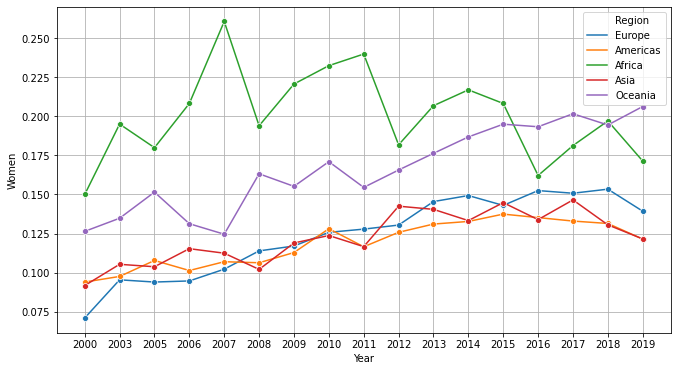

In [29]:
fig, ax = plt.subplots(figsize=(11, 6))
sns.lineplot(x='Year', y='Women', hue='Region', marker="o", data=df_region, ax=ax)
plt.grid(True)
plt.savefig("../figures/outliers_region_evolution.png", dpi=300)

## Women through the years

- Proportion of women
- Citations

In [30]:
cite = pd.merge(cite,
                all_people[["Short-Id", "gender"]],
                how="left",
                left_on="target",
                right_on="Short-Id")

In [31]:
cite = cite[cite.gender.notna()]

In [32]:
women = []
women_cites = []
years = []
regions = []
for region in all_people.region.unique():
    for year in [2000, 2003] + list(range(2005, 2020)):
        regions.append(region)
        years.append(year)
        if year == 2000:
            chunk = cite[(cite.s_year <= year) & (cite.region==region)]
        elif year == 2003:
            chunk = cite[(cite.s_year > 2000) & (cite.s_year <= 2003) & (cite.region==region)]
        elif year == 2005:
            chunk = cite[(cite.s_year > 2003) & (cite.s_year <= 2005) & (cite.region==region)]
        else:
            chunk = cite[(cite.s_year == year) & (cite.region==region)]
        npeople = chunk.target.nunique()
        nwomen = chunk[chunk.gender=="female"].target.nunique()
        women.append(nwomen / npeople)
        ncites = chunk.shape[0]
        nwomencites = chunk[chunk.gender=='female'].shape[0]
        women_cites.append(nwomencites / ncites)
df_women = pd.DataFrame({"Year": years,
                        "Region": regions,
                        "Women": women,
                        "Women cites": women_cites})

In [33]:
df_women["Year"] = df_women["Year"].astype(str)

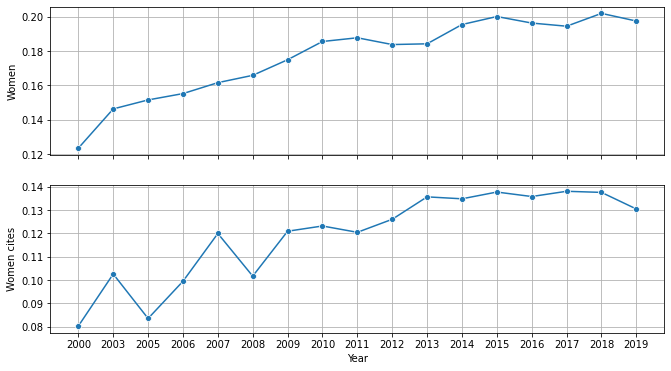

In [34]:
fig, axs = plt.subplots(2,1, figsize=(11, 6), sharex=True)
sns.lineplot(x="Year", y="Women", marker="o",  ci=None, data=df_women, ax=axs[0])
sns.lineplot(x="Year", y="Women cites", marker="o",  ci=None, data=df_women, ax=axs[1])

axs[0].grid()
axs[1].grid()

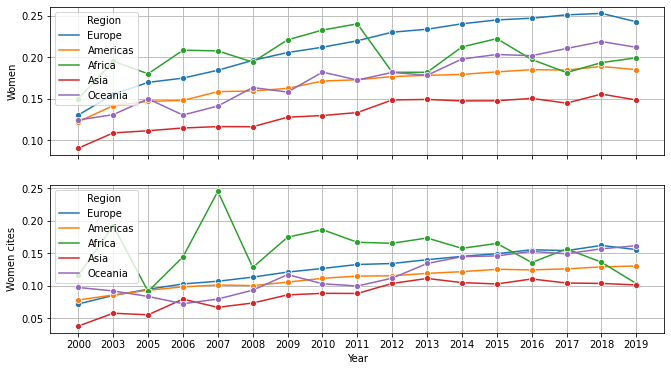

In [35]:
fig, axs = plt.subplots(2,1, figsize=(11, 6), sharex=True)
sns.lineplot(x="Year", y="Women", marker="o", hue="Region",  ci=None, data=df_women, ax=axs[0])
sns.lineplot(x="Year", y="Women cites", marker="o",  hue="Region", ci=None, data=df_women, ax=axs[1])

axs[0].grid()
axs[1].grid()

# Main core and outliers in the overal network

In [36]:
cite = pd.merge(cite,
                all_people[["Short-Id", "gender"]].rename(columns={"gender":"gender_s"}),
                how="left",
                left_on="source",
                right_on="Short-Id")

In [37]:
cite['s_year'] = cite['s_year'].astype(int).astype(str)

In [38]:
Y = cite['s_year'].value_counts()

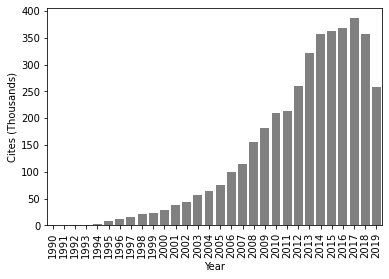

In [39]:
sns.barplot(x=Y.index, y=Y.values/1000, color='gray')
plt.xticks(rotation=90)
plt.ylabel("Cites (Thousands)")
plt.xlabel("Year")
plt.savefig('../figures/citation_distribution.png', dpi=300);

In [40]:
cite.gender.value_counts(normalize=True)

male      0.875251
female    0.124749
Name: gender, dtype: float64

In [41]:
cite.gender_s.value_counts(normalize=True)

male      0.829791
female    0.170209
Name: gender_s, dtype: float64

In [42]:
cite[(cite.gender_s=='female') & (cite.target.isin(people[people.group=='B']["Short-Id"].values))]['gender'].value_counts(normalize=True)

female    0.567982
male      0.432018
Name: gender, dtype: float64

In [43]:
cite[(cite.gender_s=='female') & (cite.target.isin(people[people.group=='A']["Short-Id"].values))]['gender'].value_counts(normalize=True)

female    0.574809
male      0.425191
Name: gender, dtype: float64

In [44]:
cite[(cite.gender_s=='male') & (cite.target.isin(people[people.group=='B']["Short-Id"].values))]['gender'].value_counts(normalize=True)

female    0.500764
male      0.499236
Name: gender, dtype: float64

In [45]:
cite[(cite.gender_s=='male') & (cite.target.isin(people[people.group=='A']["Short-Id"].values))]['gender'].value_counts(normalize=True)

male      0.501672
female    0.498328
Name: gender, dtype: float64

In [46]:
cite[cite.gender_s=='female']['gender'].value_counts(normalize=True)

male      0.846392
female    0.153608
Name: gender, dtype: float64

In [47]:
cite[cite.gender_s=='male']['gender'].value_counts(normalize=True)

male      0.880103
female    0.119897
Name: gender, dtype: float64

In [48]:
cite.head()

,target,t_year,t_journal,source,s_year,s_journal,Short-Id_x,region,Short-Id_y,gender,Short-Id,gender_s
0,pal66,2018.0,repec:aag:wpaper,pmc90,2019,repec:gam:jsusta,pal66,Oceania,pal66,male,pmc90,male
1,pmc90,2018.0,repec:aag:wpaper,pal66,2019,repec:gam:jsusta,pmc90,Europe,pmc90,male,pal66,male
2,pjo356,2001.0,repec:abg:anprac,plo511,2017,repec:nax:conyad,pjo356,Europe,pjo356,female,NaN,NaN
3,pba1182,2015.0,repec:abz:journl,pze104,2016,repec:abz:journl,pba1182,Europe,pba1182,female,pze104,male
4,pze104,2015.0,repec:abz:journl,pba1182,2016,repec:abz:journl,pze104,Europe,pze104,male,pba1182,female


In [49]:
g = nx.from_pandas_edgelist(cite, source="source", target="target", create_using=nx.DiGraph)

In [50]:
g.remove_edges_from(nx.selfloop_edges(g))

In [51]:
deg = pd.DataFrame(g.degree, columns=["node", "degree"])

In [52]:
iqr = (deg.degree.quantile(.75) - deg.degree.quantile(.25))

In [53]:
mu = deg.degree.mean()

In [54]:
outliers = set([n for n, d in g.degree if d >= deg.degree.mean() + 1.5 * iqr])

In [58]:
core_nodes = set(nx.k_core(g))

In [55]:
all_people[all_people['Short-Id'].isin(outliers)].gender.value_counts(normalize=True)

male      0.881658
female    0.118342
Name: gender, dtype: float64

In [59]:
all_people[all_people['Short-Id'].isin(core_nodes)].gender.value_counts(normalize=True)

male      0.887699
female    0.112301
Name: gender, dtype: float64

In [70]:
cite[(cite.gender_s=='male') & (cite.target.isin(outliers))]['gender'].value_counts(normalize=True)

male      0.910182
female    0.089818
Name: gender, dtype: float64

In [71]:
cite[(cite.gender_s=='female') & (cite.target.isin(outliers))]['gender'].value_counts(normalize=True)

male      0.886155
female    0.113845
Name: gender, dtype: float64

In [60]:
deg.node.nunique()

43349

In [61]:
cite.target.nunique()

28782

In [62]:
len(set(outliers)) / deg.node.nunique()

0.09977162102932016

In [63]:
len(outliers) / cite.target.nunique()

0.1502675283163088

In [64]:
len(core_nodes) / cite.target.nunique()

0.10864429157112084

In [65]:
cite[cite.target.isin(outliers)].shape[0] / cite.shape[0]

0.7333658045677856

In [66]:
cite[cite.target.isin(core_nodes)].shape[0] / cite.shape[0]

0.5974964926109351

In [67]:
len(core_nodes)

3127

In [68]:
len(core_nodes & outliers) / len(core_nodes)

0.9114166933162776